In [1]:
import torch
import torch.nn as nn
import timm
from tqdm import tqdm
import methods
import os
from astropy.io import fits
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import json
from io import BytesIO
import requests
from copy import deepcopy
from astropy.nddata import Cutout2D
from torch.nn.utils.rnn import pad_sequence

## Загрузка данных

In [2]:
#get oids and tags from json
def get_oids(filepath):
    file = open(filepath)
    obj_list = json.load(file)
    file.close()

    oids = [data['oid'] for data in obj_list]
    tags = [data['tags'] for data in obj_list]
    targets = [] # 1-artefact,  0-transient
    for tag_list in tags:
        if 'artefact' in tag_list:
            targets.append(1)
        else:
            targets.append(0)
    
    return oids, targets
####################################################


oids, targets = get_oids('akb.ztf.snad.space.json')
targets = torch.tensor(targets).long()
oids = np.array(oids)

In [3]:
batch_size = 64
imgs = []
for oid in oids[:batch_size]:
    imgs.append(methods.get_img_stack(oid))


In [4]:
train = pad_sequence(imgs, batch_first=True)

In [5]:
labels = targets[:batch_size]
train.shape

torch.Size([64, 673, 28, 28])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train = train#.to(device)
labels = labels#.to(device)

## только свертка для всех изображений

In [14]:
batch_size = 256

class SimpleCNN(nn.Module):
    def __init__(self, fc=False):
        super().__init__()
        self.layers = nn.Sequential(
                                    nn.Conv2d(1, 16, 3, padding=1),
                                    nn.ReLU(),
                                    nn.MaxPool2d(2),
                                    nn.Conv2d(16, 32, 3, padding=1),
                                    nn.MaxPool2d(2),
                                    nn.ReLU(),
                                    nn.Conv2d(32, 64, 3, padding=1, bias=False),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(64),
                                    )
        if fc:
            self.fc = nn.Sequential(nn.Linear(64*7**2, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 2)
                                   )
        else:
            self.fc = False


    def forward(self, x):
        #x.shape = batch, ch, img_size
        x = self.layers(x)
        if self.fc:
            x = self.fc(nn.Flatten()(x))

        return x

In [4]:
obj_labels = targets[:50]
imgs_labels = torch.zeros(1)
imgs = torch.zeros(1,28,28)
for i, oid in enumerate(oids[:50]):
    temp = methods.get_img_stack(oid)
    imgs = torch.vstack((imgs, temp))
    imgs_labels = torch.hstack((imgs_labels, torch.full([temp.shape[0]], obj_labels[i])))


In [5]:
imgs = imgs[1:].float()
imgs_labels = imgs_labels[1:].long()

In [15]:
model = SimpleCNN(fc=True)

In [6]:
model = timm.create_model('tf_efficientnet_b0', in_chans=1)
model.conv_stem = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
model.blocks[1][0].conv_dw = nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), groups=96, bias=False)
#model.blocks[2][0].conv_dw
#model.blocks[3][0].conv_dw
model.blocks[5][0].conv_dw = nn.Conv2d(672, 672, kernel_size=(5, 5), stride=(1, 1), groups=672, bias=False)
model.classifier = nn.Linear(in_features=1280, out_features=2, bias=True)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
#model.to(device)
model.train()

SimpleCNN(
  (layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): ReLU()
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=False)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [17]:
n_epoch = 10
loss_hist = []
for _ in tqdm(range(n_epoch)):
    perm = torch.randperm(imgs.shape[0])
    flag = 0
    ep_loss = 0
    for i in range(imgs.shape[0]//batch_size):
        x = imgs[perm][flag:(i+1)*batch_size]#.to(device)
        y = imgs_labels[perm][flag:(i+1)*batch_size]#.to(device)
        flag = (i+1)*batch_size

        optimizer.zero_grad()
        out = model(x.view(-1, 1, 28, 28))
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        ep_loss += loss.item()
    loss_hist.append(ep_loss / (imgs.shape[0]//batch_size))
        

100%|███████████████████████████████████████████| 10/10 [00:39<00:00,  3.91s/it]


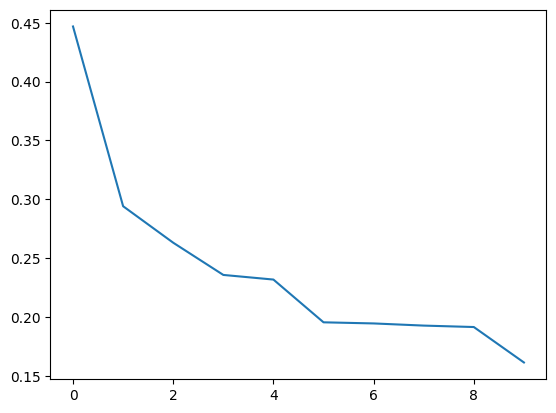

In [18]:
plt.plot(np.arange(n_epoch), loss_hist)

In [10]:
torch.save(model.state_dict(), 'effnet_conv_only')

In [5]:
model = timm.create_model('tf_efficientnet_b0', in_chans=1)
model.conv_stem = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
model.blocks[1][0].conv_dw = nn.Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), groups=96, bias=False)
#model.blocks[2][0].conv_dw
#model.blocks[3][0].conv_dw
model.blocks[5][0].conv_dw = nn.Conv2d(672, 672, kernel_size=(5, 5), stride=(1, 1), groups=672, bias=False)
model.classifier = nn.Linear(in_features=1280, out_features=2, bias=True)

model.load_state_dict(torch.load('effnet_conv_only'))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [12]:
def get_correct_count(pred, labels):
    _, predicted = torch.max(pred.data, 1)
    return (predicted.cpu() == labels.cpu()).sum().item()


@torch.inference_mode()  # this annotation disable grad computation
def validate_with_loss(model, X, Y, device="cpu"):
    criterion = nn.CrossEntropyLoss()

    flag = 0
    acc, prec, rec, Loss, f1 = 0, 0, 0, 0, 0
    batch_size = 256
    for i in range(X.shape[0]//batch_size):
        x = X[flag:(i+1)*batch_size]
        y = Y[flag:(i+1)*batch_size]
        flag = (i+1)*batch_size
        pred = model(x)
        total = y.size(0)
        correct = get_correct_count(pred, y)
        loss = criterion(pred, y)
    
        _, predicted_labels = torch.max(pred.data, 1)
        acc += correct / total
        prec += precision_score(y, predicted_labels)
        rec += recall_score(y, predicted_labels)
        f1 += f1_score(y, predicted_labels)
        Loss += loss.item()
    acc /= (X.shape[0]//batch_size)
    prec /= (X.shape[0]//batch_size)
    rec /= (X.shape[0]//batch_size)
    f1 /= (X.shape[0]//batch_size)
    Loss /= (X.shape[0]//batch_size)
    print(f"accuracy = {acc}\nloss = {Loss}\nprecision = {prec}" )
    print(f"recall = {rec}\nf1_score = {f1}")


In [12]:
test_obj_labels = targets[50:60]
y_test = torch.zeros(1)
x_test = torch.zeros(1,28,28)
for i, oid in enumerate(oids[50:60]):
    temp = methods.get_img_stack(oid)
    x_test = torch.vstack((x_test, temp))
    y_test = torch.hstack((y_test, torch.full([temp.shape[0]], test_obj_labels[i])))

In [13]:
x_test = x_test[1:].float()
y_test = y_test[1:].long()

In [19]:
validate_with_loss(model, imgs.view(imgs.shape[0], 1, 28, 28), imgs_labels)

/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classifica

accuracy = 0.9058159722222222
loss = 0.20874689818119804
precision = 0.5711130527640939
recall = 0.501127016896429
f1_score = 0.4966622931508163


/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/timofey/saimsu/astroenv/lib/python3.10/site-pack

In [50]:
validate_with_loss(model, x_test.view(x_test.shape[0], 1, 28, 28), y_test)

/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

accuracy = 0.7350260416666666
loss = 0.8011672985351955
precision = 0.1472953216374269
recall = 0.06816023284313727
f1_score = 0.08178456800927744


/home/timofey/saimsu/astroenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
print(f'0 : {torch.sum(imgs_labels == 0)}\n1 : {torch.sum(imgs_labels == 1)}')

0 : 7011
1 : 4562


## Conv3d

In [9]:
model = methods.CustomResnet3d()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model.to(device)
model.train()
n_epoch = 10

In [10]:
loss_hist = []
for epoch in range(n_epoch):
    ep_loss = 0
    optimizer.zero_grad()
    out = model(train.view(train.shape[0],1, 28, 28, train.shape[1]))
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    ep_loss += loss.item()
    loss_hist.append(ep_loss)

OutOfMemoryError: CUDA out of memory. Tried to allocate 214.00 MiB (GPU 0; 1.96 GiB total capacity; 1.28 GiB already allocated; 76.88 MiB free; 1.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

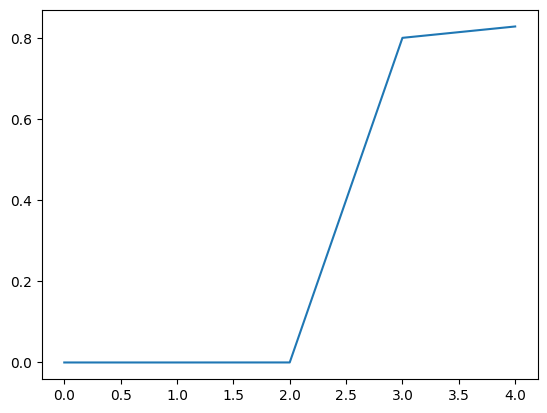

In [18]:
plt.plot(np.arange(n_epoch), loss_hist)

## RNN and conv model

In [7]:
model = methods.RBclassifier(hidden_size=128)

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
model.train()
n_epoch = 10

In [ ]:
loss_hist = []
for epoch in range(n_epoch):
    ep_loss = 0
    optimizer.zero_grad()
    out = model(train.view(train.shape[0],train.shape[1],1,28,28))
    loss = criterion(out, labels)
    loss.backward()
    optimizer.step()
    ep_loss += loss.item()
    loss_hist.append(ep_loss)

In [ ]:
plt.plot(np.arange(n_epoch), loss_hist)

## Проверка предобработки кадров

In [4]:
fits_list = os.listdir(f'data/{oids[0]}')

In [5]:
temp = fits.open(f'data/{oids[0]}/{fits_list[3]}')
test = methods.img_prep(temp)

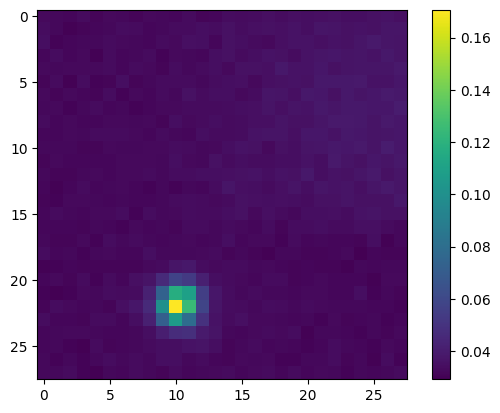

In [6]:
plt.imshow(test)
plt.colorbar()

In [7]:
test.shape

(28, 28)

In [9]:
imgs = []
fits_list = os.listdir('data/643105300009229')
for i, f in enumerate(fits_list):
    temp = fits.open(f'data/643105300009229/{f}')
    imgs.append(img_prep(temp))
    #if temp[0].data.shape != (28, 28):
     #   print(i)
    temp.close()
train = torch.tensor(imgs)

13, 13
13, 13


/tmp/ipykernel_25188/3273783828.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train = torch.tensor(imgs)


TypeError: FigureBase.colorbar() missing 1 required positional argument: 'mappable'

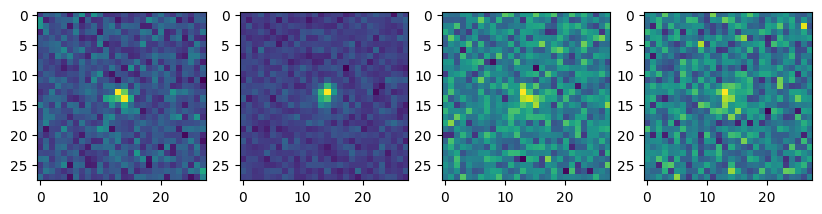

In [14]:
fig, ax = plt.subplots(1, 4, figsize=(10, 6))
ax[0].imshow(imgs[48])
ax[1].imshow(imgs[49])
ax[2].imshow(imgs[50])
ax[3].imshow(imgs[51])
fig.colorbar(cax=ax[0])

## Check if ipac cut images the same way as cutout2d

In [120]:
#temp = fits.open(f'download_cuted_fits/643105300009229/{fits_list[49]}')
url = 'https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/2018/0711/339120/ztf_20180711339120_000643_zg_c05_o_q3_sciimg.fits'
response = requests.get(url)
response.raise_for_status()
stream = BytesIO(response.content)
stream.seek(0)
hdus = fits.open(stream)


In [122]:
print(temp[0].header['OIDRA'], temp[0].header['OIDDEC'])

325.9647216796875 24.3537769317627


In [123]:
coord = SkyCoord('325.9647216796875 24.3537769317627', unit='deg', frame='icrs')
image = deepcopy(hdus[0].data)
currentWCS = WCS(hdus[0].header, hdus)
cutout = Cutout2D(image, coord, (28,28), wcs=currentWCS)
cutout_image = cutout.data #np array


In [126]:
sum(cutout_image == temp[0].data)

array([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22])